In [1]:
!pip install ydata-profiling
!pip install pyspark
!pip install wordcloud
!pip install optuna
!pip install --upgrade IPython

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import pyspark
import ydata_profiling
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from math import ceil
import torch
import torch.nn as nn
import torch.optim as optim
import random
import warnings
warnings.filterwarnings("ignore")
import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import LabelBinarizer
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from tqdm.auto import tqdm
from tqdm import trange
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import IPython
from pycaret.regression import RegressionExperiment
import time
import seaborn as sns

# Загрузка данных

In [42]:

#Это путь для загурзки в среде Практикума
pth1 = '/datasets/6_class.csv'
pth2 = 'E:\\Data\\_Projects\\datasets\\6_class.csv'

cols=["Temperature (K)", "Luminosity(L/Lo)", "Radius(R/Ro)","Absolute magnitude(Mv)","Star type","Star color"]
if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col=1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2,index_col=1)
else:
    print('Something is wrong')

In [43]:
df=df.drop(['Unnamed: 0'], axis=1)
df.sample(10)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
Unnamed: 0.1,,,,,,
49,33750,220000.00000,26.0000,-6.10,4,Blue
65,3295,0.00098,0.1320,17.13,0,Red
15,3340,0.00380,0.2400,13.07,1,Red
153,16390,1278.00000,5.6800,-3.32,3,Blue-white
156,26140,14520.00000,5.4900,-3.80,3,Blue-white
151,8945,38.00000,2.4870,0.12,3,Blue-White
101,40000,813000.00000,14.0000,-6.23,4,Blue
122,3218,0.00054,0.1100,20.02,0,Red
63,2835,0.00034,0.0918,16.96,0,Red


In [5]:
ydata_profiling.ProfileReport(df) 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Можно сделать следующие выводы на основе описательной статистики ydata_profiling.**

- Нам попался незамусоренный набор данных, явные дубликаты и пропуски отсутствуют.
- Данных конечно маловато 240 заёзд, я сылшал их больше.
- Наша целевая переменная - температура в Кельвинах - имеет крайне большой разброс и вообще выглядит как несколько кластеров в которых данные распределены более-менее нормально. Не считая огромного пика в самом начале.
- Светимость (Lо) имеет похожий раброс значений. Но здесь данные ещё хуже нормализованы и проблема выбросов стоит ещё более остро.
- Радиус (Ro) похож в плане гардиозного пика в начале, но здесь 75% значений ниже 42, а оставишеся 25% размазаны по диапазону до 1948.
- Блеск звезды Mv = имеет крайне необычное распределение, похожее на синусоиду, единственный параметр, который может быть сильно отрицательным.
- С типом звезды всё просто. Есть 6 типов и каждый встречается 40 раз.
- С цветом всё интереснее - там есть неявные дубликаты, например Blue-white и Blue white, но в целом с десяток уникальный категорий, около половины объектов помечены как "Red". Большая часть цветов встречается менее чем в 5 случаях.

**Наблюдается сильная взаимная корреляция!**

- Radius(R/Ro) и Luminosity(L/Lo)=0,89
- Absolute magnitude(Mv)	и Luminosity(L/Lo)=-0,89
- Корреляция для типа и цвета - непоказательна, так как это категориальные переменные.

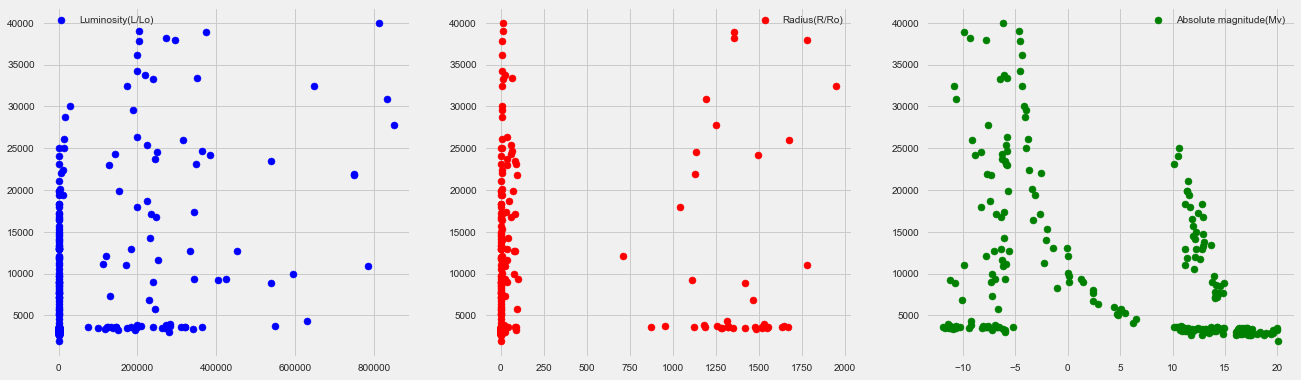

In [44]:
# Две строки, два столбца. Текущая ячейка - 1
f, axs = plt.subplots(1, 3, figsize=(20, 6))
plt.subplot (1, 3,1)
plt.scatter( 'Luminosity(L/Lo)','Temperature (K)', data=df, marker='o', color='blue', label='Luminosity(L/Lo)')
plt.legend()
plt.subplot (1, 3,2)
plt.scatter( 'Radius(R/Ro)','Temperature (K)', data=df, marker='o', color='red', label='Radius(R/Ro)')
plt.legend()
plt.subplot (1, 3,3)
plt.scatter( 'Absolute magnitude(Mv)','Temperature (K)', data=df, marker='o', color='green', label='Absolute magnitude(Mv)')
# show legend
plt.legend()

# show graph
plt.show()

Напрашивается единственный этап предобработки - вычищение неявных дубликатов в цветах звёзд.

## Предобработка данных

In [45]:
df['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [46]:
def uniform_stars(df):
    di={'yellowish':'Yellowish','Blue white ':'Blue-White','white':'White','Blue white':'Blue-White','Blue-Whiet':'Blue-White',
        'Blue White':'Blue-White','Blue-white':'Blue-White','Blue White':'Blue-White','Blue ':'Blue'}
    df['Star color'] = df['Star color'].replace(di)
    df['Star color'].unique()
    return df

In [47]:
def higher_radius(x):
    if x>100:
        return x
    else:
        return 708
    
def higher_luminosity(x):
    if x>1:
        return x
    else:
        return 1.35
    
def magnitizer_minus(x):
    if x<7:
        return x
    else:
        return 6.99999
    
def magnitizer_plus(x):
    if x>=7:
        return x
    else:
        return 7.0001

In [138]:
#Теперь сгладим несколько выбросы у радиуса звезды:
def cut_extreme_radius(d):
    #max=df['Radius(R/Ro)'].max()*0.85
    max=100
    d['Radius(R/Ro)']=d['Radius(R/Ro)'].apply ( lambda x: x if x < max else max)
    #max=df['Luminosity(L/Lo)'].max()*0.85
    max=1
    d['Luminosity(L/Lo)']=d['Luminosity(L/Lo)'].apply ( lambda x: x if x < max else max)
    #min=df['Radius(R/Ro)'].min()*1.5
    min=np.quantile(df['Radius(R/Ro)'], 0.05)
    df['Radius(R/Ro)']=df['Radius(R/Ro)'].apply ( lambda x: x if x > min else min)
    #max=df['Luminosity(L/Lo)'].max()*0.85
    #min=np.quantile(df['Luminosity(L/Lo)'], 0.0005)
    #df['Luminosity(L/Lo)']=df['Luminosity(L/Lo)'].apply ( lambda x: x if x > max else max)
    return d

In [139]:
#num_c=['Luminosity(L/Lo)','Radius(R/Ro)','higher_radius','higher_luminosity','neg_magnitude','pos_magnitude']
num_c=['Luminosity(L/Lo)','Radius(R/Ro)','Absolute magnitude(Mv)']
cat_c=['Star type','Star color']

In [173]:
#Завернём всю предобработку в одну функцию, чтобы потом использовать на конвейере
def preworking(d):

    d=uniform_stars(d)
    #d=clusterize(d)
    #d['higher_radius'] = d['Radius(R/Ro)'].map(higher_radius)
    #d['higher_luminosity'] = d['Luminosity(L/Lo)'].map(higher_luminosity)
    #d=cut_extreme_radius(d)
    #d['magnitude^2']=df['Absolute magnitude(Mv)'].apply ( lambda x: x **2)
    d['neg_magnitude'] = d['Absolute magnitude(Mv)'].map(magnitizer_minus)
    d['pos_magnitude'] = d['Absolute magnitude(Mv)'].map(magnitizer_plus)
    #d=d.drop(['Absolute magnitude(Mv)'], axis=1)

    
    
    return d

def pipelining(d):
    d[num_c]=sc.transform(d[num_c])
    dc=ohe.transform(d[cat_c]).toarray()
    result1 = ['Star type_' + str(type) for type in (ohe.categories_[0].tolist())]
    result2 = ['Star color type_' + str(type) for type in (ohe.categories_[1].tolist())]
    cols=result1+result2
    dc=pd.DataFrame(dc,columns=cols,index=d.index)
    d = pd.concat([d, dc], axis=1,ignore_index=False, sort=False)
    d=d.drop(['Star type','Star color'], axis=1)   
    return d

## Построение модели

In [174]:

s = RegressionExperiment()
s.setup(df, target = 'Temperature (K)', session_id = 123)
best = s.compare_models()
best

,Description,Value
0,Session id,123
1,Target,Temperature (K)
2,Target type,Regression
3,Original data shape,"(240, 6)"
4,Transformed data shape,"(240, 22)"
5,Transformed train set shape,"(168, 22)"
6,Transformed test set shape,"(72, 22)"
7,Numeric features,4
8,Categorical features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,3426.7414,27460545.2346,5128.9094,0.6018,0.4738,0.4060,0.0220
lr,Linear Regression,3540.6605,27800236.1325,5147.7446,0.5936,0.6723,0.4416,0.0220
lasso,Lasso Regression,3626.8254,28401995.9895,5200.3333,0.5890,0.7293,0.4533,0.0230
llar,Lasso Least Angle Regression,3627.0328,28406698.8593,5200.8698,0.5890,0.7283,0.4533,0.0240
et,Extra Trees Regressor,2598.6392,27259479.3261,5070.2453,0.5588,0.2880,0.2106,0.0670
rf,Random Forest Regressor,2679.0303,26416541.8754,4969.8957,0.5198,0.2904,0.2288,0.0870
catboost,CatBoost Regressor,2842.9654,27177241.5064,5007.2140,0.4896,0.3236,0.2670,0.3890
ada,AdaBoost Regressor,3658.5546,31532994.6179,5469.6448,0.4788,0.4251,0.4523,0.0410
lightgbm,Light Gradient Boosting Machine,3111.3420,26821074.5121,4944.2593,0.4771,0.4021,0.3422,0.0250
gbr,Gradient Boosting Regressor,3060.7229,29820226.8461,5302.8214,0.4641,0.3275,0.2686,0.0480


Ridge(random_state=123)

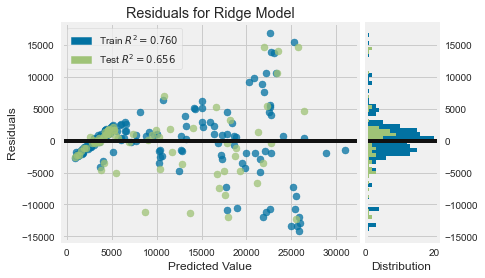

In [142]:
s.plot_model(best, plot = 'residuals')

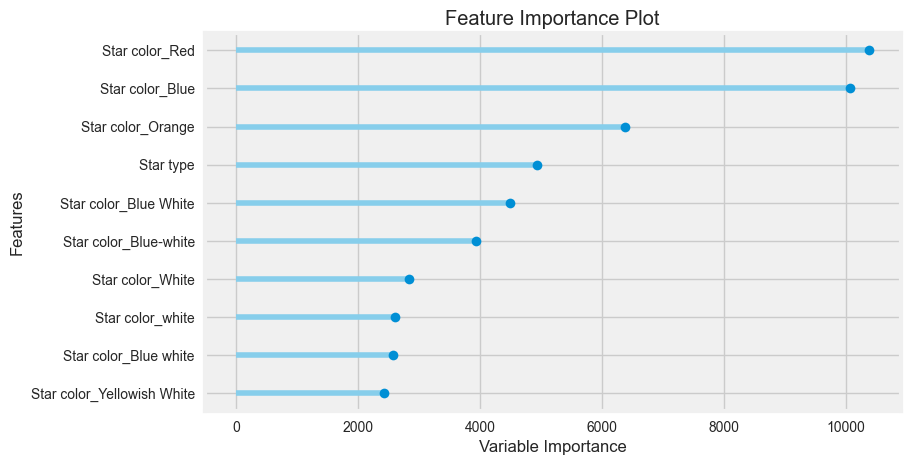

In [143]:
s.plot_model(best, plot = 'feature')

In [378]:
# Осуществим разделение данных на выборки с использованием случайного страининга
train_indices, test_indices = train_test_split(np.arange(df.shape[0]), test_size=0.25, random_state=42)

# Создание двух выборок
train_data = df.iloc[train_indices]
test_data = df.iloc[test_indices]

# Проверка размера каждой выборки
print("Размер обучающей выборки:", len(train_data))
print("Размер валидационной выборки:", len(test_data))

Размер обучающей выборки: 180
Размер валидационной выборки: 60


In [379]:
df_train=preworking(train_data)
df_test=preworking(test_data)
sc=StandardScaler()
ohe=OneHotEncoder(handle_unknown='ignore')
sc.fit(df_train[num_c])
ohe.fit(df_train[cat_c])

df_test=pipelining(df_test)

In [380]:
def bulr_feature(down,up):
    alpha=np.random.uniform(down,up)
    #print("alpha=",alpha)
    #x=x*(1+alpha/100)
    return alpha

In [381]:
s=df_train
types=list(s['Star type'].unique())
colors=list(s['Star color'].unique())
extender=pd.DataFrame(columns=s.columns)
solo_alpha=0.1
insert=[]

for type in types:
    for color in colors:
        star_slice=s[(s['Star type']==type) & (s['Star color']==color)]
        if len(star_slice)>=1:
            #display(star_slice)
            for i in range(50):
                extender.loc[len(extender)] = star_slice.iloc[0]
                extender['Temperature (K)'].iloc[-1]=bulr_feature(star_slice['Temperature (K)'].iloc[-1]*(1-solo_alpha),star_slice['Temperature (K)'].iloc[-1]*(1+solo_alpha))
                for c in cat_c:
                    extender[c].iloc[-1]=star_slice[c].iloc[-1]
                for n in num_c:
                    extender[n].iloc[-1]=bulr_feature(star_slice[n].iloc[-1]*(1-solo_alpha),star_slice[n].iloc[-1]*(1+solo_alpha))
        #f len(star_slice)>1:
            #display(star_slice)

         #  for i in range(50):
          #     extender.loc[len(extender)] = star_slice.iloc[0]
                
                #print(random.randint(0, len(star_slice)))
           #    extender['Temperature (K)'].iloc[-1]=star_slice['Temperature (K)'].iloc[random.randint(0, len(star_slice)-1)]
                #display(exteder)
                
            #   for c in cat_c:
             #      extender[c].iloc[-1]=star_slice[c].iloc[-1]
             #  for n in num_c:
                    #min=star_slice[n].min()
                    #max=star_slice[n].max()
                    #if min==max:
                    #    min=min*(1-solo_alpha)
                    #    max=max*(1+solo_alpha)
              #     extender[n].iloc[-1]=star_slice[n].iloc[random.randint(0, len(star_slice)-1)]
        
        #print(exteder)

            
                

#exteder.loc[len(exteder)] = star_slice.iloc[1]
        
#sample_size=np.random.randint(10)
#alpha=1
extender.sample(10)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,neg_magnitude,pos_magnitude
434,22574.881301,0.055523,0.009774,9.649763,2,Blue-White,6.99999,12.1700
919,3560.085138,531472.678461,1691.431194,-7.886475,5,Orange,-8.05000,7.0001
887,10029.755491,412635.853583,1198.876345,-10.795622,5,White,-11.23000,7.0001
807,41329.171448,287326.022331,1728.282173,-7.824733,5,Blue,-9.29000,7.0001
762,4363.180475,254321.536834,1611.464364,-10.265210,5,Red,-10.25000,7.0001
686,7532.949518,0.000317,0.011631,13.508118,2,White-Yellow,6.99999,14.0900
932,3460.14901,506855.374965,1593.215010,-8.076131,5,Orange,-8.05000,7.0001
28,20470.463709,11428.111555,6.578845,-3.483100,3,Blue-White,-2.30000,7.0001
592,7370.366939,0.000481,0.012227,15.355471,2,White,6.99999,13.7800
469,15268.410953,0.001177,0.011735,13.011961,2,Blue,6.99999,11.6600


In [382]:
X_upsample=pd.concat([df_train, extender])
#X_upsample=df_train
print(X_upsample.shape)

(1180, 8)


## Построение базовой нейронной сети

In [383]:
#Здадим консатны для воспроизоводимости
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [384]:
df_train=pipelining(X_upsample)
X_train=df_train.drop(columns=['Temperature (K)'])
X_test=df_test.drop(columns=['Temperature (K)'])     
y_train = df_train['Temperature (K)']
y_test = df_test['Temperature (K)']

In [385]:
X_train = torch.FloatTensor(np.ascontiguousarray(X_train,dtype = np.float32))
X_test = torch.FloatTensor(np.ascontiguousarray(X_test,dtype = np.float32))
y_train = torch.FloatTensor(np.ascontiguousarray(y_train,dtype = np.float32))
y_test = torch.FloatTensor(np.ascontiguousarray(y_test,dtype = np.float32))

In [386]:
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

In [387]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=50):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [388]:
#Напишем процедуру, которая будут создавать на модель, принимая на вход кое-какие гипер-параметры, которые мы потом будем оптимизировать
def customize_model(ins=20,layers=2,neurons=[8,4],drops=[0.1,0.2]):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = layers
    layers = []
    in_features = ins
    layers.append(nn.BatchNorm1d(in_features))
   
    for i in range(n_layers):
        out_features = neurons[i]
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.LeakyReLU())
        layers.append(nn.Dropout(drops[i]))
        in_features = out_features
    layers.append(nn.Linear(in_features, 1))
    layers.append(nn.ReLU())

    return nn.Sequential(*layers)

In [389]:
#Напишем процедуру обучения нейросети
def train_net(epochs=10, batch_size=16):
    early_stopper = EarlyStopper(patience=100, min_delta=100)
    for epoch in trange(epochs):
        net.train()
        for batch in train_dataloader:
            features_train, targets_train = batch # просто выгружаем данные 
            optimizer.zero_grad()
            preds = net.forward(features_train).flatten()
            loss_value = torch.sqrt(loss(preds, targets_train))
            loss_value.backward()
            optimizer.step()
        if epoch % 100== 0:
            predicted = [] 
            with torch.no_grad():
                net.eval()
                for batch in test_dataloader:
                    features_test, targets_test = batch # просто выгружаем данные
                    test_preds = net.forward(features_test).flatten()
                    predicted.append(test_preds)
                    RMSE_loss = torch.sqrt(loss(test_preds, targets_test))            
            predicted = torch.cat(predicted).detach().numpy()
            RMSE = mean_squared_error(y_test, predicted, squared=False)
            
            if early_stopper.early_stop(RMSE):             
                print('Early Stoppning!!!')
                print(f'Last RMSE test {RMSE}')
                break
            else:
                print(f"epoch:{epoch}, RMSE test: {RMSE}")
    
    return net

In [390]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 15
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = customize_model(ins=n_in_neurons,layers=2,neurons=[n_hidden_neurons_1,n_hidden_neurons_2],drops=[0.4,0.6])
optimizer = torch.optim.Adam(net.parameters(), lr=0.018, weight_decay=1e-2) 
loss = nn.MSELoss()

num_epochs = 9000
batch_size = 80

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=0)

In [391]:
net=train_net(epochs=num_epochs, batch_size=batch_size)

  0%|                                                                                 | 6/9000 [00:00<05:11, 28.88it/s]

epoch:0, RMSE test: 14621.0126953125


  1%|▉                                                                              | 105/9000 [00:03<04:59, 29.67it/s]

epoch:100, RMSE test: 4689.00927734375


  2%|█▊                                                                             | 204/9000 [00:06<04:55, 29.82it/s]

epoch:200, RMSE test: 4861.02294921875


  3%|██▋                                                                            | 304/9000 [00:10<04:54, 29.58it/s]

epoch:300, RMSE test: 4958.28369140625


  4%|███▌                                                                           | 405/9000 [00:13<04:54, 29.22it/s]

epoch:400, RMSE test: 4718.25146484375


  6%|████▍                                                                          | 504/9000 [00:17<04:48, 29.49it/s]

epoch:500, RMSE test: 4724.40771484375


  7%|█████▎                                                                         | 604/9000 [00:20<04:44, 29.54it/s]

epoch:600, RMSE test: 4769.0146484375


  8%|██████▏                                                                        | 706/9000 [00:23<04:41, 29.45it/s]

epoch:700, RMSE test: 5195.12646484375


  9%|███████                                                                        | 804/9000 [00:27<04:36, 29.61it/s]

epoch:800, RMSE test: 4977.35595703125


 10%|███████▉                                                                       | 904/9000 [00:30<04:33, 29.58it/s]

epoch:900, RMSE test: 4853.97900390625


 11%|████████▋                                                                     | 1004/9000 [00:33<04:31, 29.50it/s]

epoch:1000, RMSE test: 4839.90625


 12%|█████████▌                                                                    | 1106/9000 [00:37<04:28, 29.41it/s]

epoch:1100, RMSE test: 4716.45556640625


 13%|██████████▍                                                                   | 1204/9000 [00:40<04:26, 29.29it/s]

epoch:1200, RMSE test: 4841.89404296875


 15%|███████████▎                                                                  | 1306/9000 [00:44<04:21, 29.47it/s]

epoch:1300, RMSE test: 5018.5029296875


 16%|████████████▏                                                                 | 1404/9000 [00:47<04:17, 29.55it/s]

epoch:1400, RMSE test: 4880.11767578125


 17%|█████████████                                                                 | 1504/9000 [00:50<04:13, 29.60it/s]

epoch:1500, RMSE test: 4845.19677734375


 18%|█████████████▉                                                                | 1605/9000 [00:54<04:10, 29.54it/s]

epoch:1600, RMSE test: 4882.517578125


 19%|██████████████▊                                                               | 1705/9000 [00:57<04:06, 29.59it/s]

epoch:1700, RMSE test: 4777.88232421875


 20%|███████████████▋                                                              | 1804/9000 [01:00<04:04, 29.47it/s]

epoch:1800, RMSE test: 4864.345703125


 21%|████████████████▌                                                             | 1905/9000 [01:04<04:01, 29.38it/s]

epoch:1900, RMSE test: 4704.0244140625


 22%|█████████████████▍                                                            | 2005/9000 [01:07<03:56, 29.53it/s]

epoch:2000, RMSE test: 4867.572265625


 23%|██████████████████▏                                                           | 2104/9000 [01:10<03:53, 29.55it/s]

epoch:2100, RMSE test: 4831.4736328125


 25%|███████████████████                                                           | 2206/9000 [01:14<03:49, 29.57it/s]

epoch:2200, RMSE test: 4896.62255859375


 26%|███████████████████▉                                                          | 2304/9000 [01:17<03:46, 29.53it/s]

epoch:2300, RMSE test: 4900.169921875


 27%|████████████████████▊                                                         | 2406/9000 [01:21<03:41, 29.76it/s]

epoch:2400, RMSE test: 4826.79150390625


 28%|█████████████████████▋                                                        | 2505/9000 [01:24<03:38, 29.79it/s]

epoch:2500, RMSE test: 4807.74365234375


 29%|██████████████████████▌                                                       | 2605/9000 [01:27<03:57, 26.93it/s]

epoch:2600, RMSE test: 4933.18994140625


 30%|███████████████████████▍                                                      | 2705/9000 [01:31<03:33, 29.47it/s]

epoch:2700, RMSE test: 5125.38232421875


 31%|████████████████████████▎                                                     | 2805/9000 [01:34<03:29, 29.57it/s]

epoch:2800, RMSE test: 4879.2978515625


 32%|█████████████████████████▏                                                    | 2903/9000 [01:37<03:26, 29.46it/s]

epoch:2900, RMSE test: 4903.1494140625


 33%|██████████████████████████                                                    | 3005/9000 [01:41<03:22, 29.54it/s]

epoch:3000, RMSE test: 4848.8046875


 34%|██████████████████████████▉                                                   | 3104/9000 [01:44<03:18, 29.68it/s]

epoch:3100, RMSE test: 4867.72802734375


 36%|███████████████████████████▊                                                  | 3205/9000 [01:48<03:14, 29.73it/s]

epoch:3200, RMSE test: 4884.49853515625


 37%|████████████████████████████▋                                                 | 3306/9000 [01:51<03:12, 29.62it/s]

epoch:3300, RMSE test: 4874.92236328125


 38%|█████████████████████████████▌                                                | 3405/9000 [01:54<03:10, 29.41it/s]

epoch:3400, RMSE test: 4858.9638671875


 39%|██████████████████████████████▎                                               | 3504/9000 [01:58<03:05, 29.58it/s]

epoch:3500, RMSE test: 4924.51123046875


 40%|███████████████████████████████▎                                              | 3606/9000 [02:01<03:01, 29.64it/s]

epoch:3600, RMSE test: 4851.3212890625


 41%|████████████████████████████████                                              | 3706/9000 [02:04<02:58, 29.67it/s]

epoch:3700, RMSE test: 5101.74658203125


 42%|████████████████████████████████▉                                             | 3806/9000 [02:08<02:56, 29.50it/s]

epoch:3800, RMSE test: 4938.28173828125


 43%|█████████████████████████████████▊                                            | 3904/9000 [02:11<02:53, 29.33it/s]

epoch:3900, RMSE test: 4892.97314453125


 44%|██████████████████████████████████▋                                           | 4005/9000 [02:15<02:48, 29.60it/s]

epoch:4000, RMSE test: 4801.7822265625


 46%|███████████████████████████████████▌                                          | 4104/9000 [02:18<02:45, 29.66it/s]

epoch:4100, RMSE test: 4798.48974609375


 47%|████████████████████████████████████▍                                         | 4205/9000 [02:21<02:42, 29.56it/s]

epoch:4200, RMSE test: 4858.68212890625


 48%|█████████████████████████████████████▎                                        | 4305/9000 [02:25<02:37, 29.74it/s]

epoch:4300, RMSE test: 4843.01318359375


 49%|██████████████████████████████████████▏                                       | 4404/9000 [02:28<02:34, 29.84it/s]

epoch:4400, RMSE test: 4864.0859375


 50%|███████████████████████████████████████                                       | 4505/9000 [02:31<02:31, 29.66it/s]

epoch:4500, RMSE test: 5100.2119140625


 51%|███████████████████████████████████████▉                                      | 4605/9000 [02:35<02:28, 29.65it/s]

epoch:4600, RMSE test: 4940.4453125


 52%|████████████████████████████████████████▊                                     | 4706/9000 [02:38<02:25, 29.52it/s]

epoch:4700, RMSE test: 5143.9462890625


 53%|█████████████████████████████████████████▋                                    | 4805/9000 [02:42<02:21, 29.71it/s]

epoch:4800, RMSE test: 4866.51171875


 55%|██████████████████████████████████████████▌                                   | 4905/9000 [02:45<02:17, 29.70it/s]

epoch:4900, RMSE test: 4983.556640625


 56%|███████████████████████████████████████████▎                                  | 5004/9000 [02:48<02:14, 29.66it/s]

epoch:5000, RMSE test: 4921.46240234375


 57%|████████████████████████████████████████████▏                                 | 5105/9000 [02:52<02:11, 29.55it/s]

epoch:5100, RMSE test: 4852.8447265625


 58%|█████████████████████████████████████████████                                 | 5206/9000 [02:55<02:07, 29.68it/s]

epoch:5200, RMSE test: 4872.62890625


 59%|█████████████████████████████████████████████▉                                | 5304/9000 [02:58<02:04, 29.68it/s]

epoch:5300, RMSE test: 4990.4208984375


 60%|██████████████████████████████████████████████▊                               | 5404/9000 [03:02<02:02, 29.47it/s]

epoch:5400, RMSE test: 5138.90576171875


 61%|███████████████████████████████████████████████▋                              | 5504/9000 [03:05<01:57, 29.65it/s]

epoch:5500, RMSE test: 4941.611328125


 62%|████████████████████████████████████████████████▌                             | 5604/9000 [03:08<01:54, 29.69it/s]

epoch:5600, RMSE test: 4929.92822265625


 63%|█████████████████████████████████████████████████▍                            | 5706/9000 [03:12<01:51, 29.55it/s]

epoch:5700, RMSE test: 4989.84228515625


 64%|██████████████████████████████████████████████████▎                           | 5804/9000 [03:15<01:47, 29.62it/s]

epoch:5800, RMSE test: 4896.88330078125


 66%|███████████████████████████████████████████████████▏                          | 5906/9000 [03:19<01:45, 29.44it/s]

epoch:5900, RMSE test: 5061.951171875


 67%|████████████████████████████████████████████████████                          | 6004/9000 [03:22<01:41, 29.56it/s]

epoch:6000, RMSE test: 4973.677734375


 68%|████████████████████████████████████████████████████▉                         | 6105/9000 [03:25<01:37, 29.82it/s]

epoch:6100, RMSE test: 5000.2177734375


 69%|█████████████████████████████████████████████████████▊                        | 6206/9000 [03:29<01:35, 29.37it/s]

epoch:6200, RMSE test: 4969.5068359375


 70%|██████████████████████████████████████████████████████▋                       | 6306/9000 [03:32<01:30, 29.61it/s]

epoch:6300, RMSE test: 4965.525390625


 71%|███████████████████████████████████████████████████████▌                      | 6405/9000 [03:35<01:27, 29.61it/s]

epoch:6400, RMSE test: 4947.75


 72%|████████████████████████████████████████████████████████▍                     | 6506/9000 [03:39<01:23, 29.77it/s]

epoch:6500, RMSE test: 4948.390625


 73%|█████████████████████████████████████████████████████████▎                    | 6606/9000 [03:42<01:20, 29.84it/s]

epoch:6600, RMSE test: 4927.59033203125


 74%|██████████████████████████████████████████████████████████                    | 6704/9000 [03:45<01:17, 29.45it/s]

epoch:6700, RMSE test: 5058.875


 76%|██████████████████████████████████████████████████████████▉                   | 6804/9000 [03:49<01:13, 29.69it/s]

epoch:6800, RMSE test: 4980.82177734375


 77%|███████████████████████████████████████████████████████████▊                  | 6905/9000 [03:52<01:10, 29.58it/s]

epoch:6900, RMSE test: 5115.33203125


 78%|████████████████████████████████████████████████████████████▋                 | 7005/9000 [03:56<01:07, 29.76it/s]

epoch:7000, RMSE test: 5013.00634765625


 79%|█████████████████████████████████████████████████████████████▌                | 7105/9000 [03:59<01:04, 29.58it/s]

epoch:7100, RMSE test: 5070.28662109375


 80%|██████████████████████████████████████████████████████████████▍               | 7205/9000 [04:02<01:00, 29.63it/s]

epoch:7200, RMSE test: 5002.73046875


 81%|███████████████████████████████████████████████████████████████▎              | 7304/9000 [04:06<00:56, 29.78it/s]

epoch:7300, RMSE test: 5070.9931640625


 82%|████████████████████████████████████████████████████████████████▏             | 7404/9000 [04:09<00:53, 29.58it/s]

epoch:7400, RMSE test: 4853.2978515625


 83%|█████████████████████████████████████████████████████████████████             | 7506/9000 [04:12<00:50, 29.84it/s]

epoch:7500, RMSE test: 4966.1572265625


 84%|█████████████████████████████████████████████████████████████████▉            | 7603/9000 [04:16<00:47, 29.57it/s]

epoch:7600, RMSE test: 5040.16845703125


 86%|██████████████████████████████████████████████████████████████████▊           | 7704/9000 [04:19<00:43, 29.65it/s]

epoch:7700, RMSE test: 5099.64013671875


 87%|███████████████████████████████████████████████████████████████████▋          | 7806/9000 [04:22<00:40, 29.61it/s]

epoch:7800, RMSE test: 5101.7666015625


 88%|████████████████████████████████████████████████████████████████████▌         | 7904/9000 [04:26<00:36, 29.68it/s]

epoch:7900, RMSE test: 5042.99609375


 89%|█████████████████████████████████████████████████████████████████████▎        | 8004/9000 [04:29<00:33, 29.71it/s]

epoch:8000, RMSE test: 5025.591796875


 90%|██████████████████████████████████████████████████████████████████████▏       | 8104/9000 [04:32<00:30, 29.77it/s]

epoch:8100, RMSE test: 4921.5654296875


 91%|███████████████████████████████████████████████████████████████████████       | 8205/9000 [04:36<00:26, 29.90it/s]

epoch:8200, RMSE test: 5091.078125


 92%|███████████████████████████████████████████████████████████████████████▉      | 8305/9000 [04:39<00:23, 29.95it/s]

epoch:8300, RMSE test: 5180.32275390625


 93%|████████████████████████████████████████████████████████████████████████▊     | 8406/9000 [04:43<00:19, 29.76it/s]

epoch:8400, RMSE test: 5081.94482421875


 94%|█████████████████████████████████████████████████████████████████████████▋    | 8504/9000 [04:46<00:16, 29.79it/s]

epoch:8500, RMSE test: 5074.26513671875


 96%|██████████████████████████████████████████████████████████████████████████▌   | 8606/9000 [04:49<00:13, 29.43it/s]

epoch:8600, RMSE test: 4979.43896484375


 97%|███████████████████████████████████████████████████████████████████████████▍  | 8706/9000 [04:53<00:10, 29.34it/s]

epoch:8700, RMSE test: 5115.10986328125


 98%|████████████████████████████████████████████████████████████████████████████▎ | 8806/9000 [04:56<00:06, 29.81it/s]

epoch:8800, RMSE test: 4914.95654296875


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8905/9000 [04:59<00:03, 29.74it/s]

epoch:8900, RMSE test: 5056.470703125


100%|██████████████████████████████████████████████████████████████████████████████| 9000/9000 [05:02<00:00, 29.70it/s]


In [400]:
full_test_pred = net.forward(X_test).flatten()
RMSE = mean_squared_error(y_test.detach().numpy(), full_test_pred.detach().numpy(), squared=False)
RMSE

7514.1553

In [393]:
def fact_forecast(test_preds, y_test):
    
    '''Функция для визуализации качества регрессии "Факт-прогноз"'''
    plt.style.use('fivethirtyeight')
    y1 = torch.FloatTensor(test_preds)
    y1 = y1.detach().numpy().reshape([-1])
    y2 = y_test.detach().numpy().reshape([-1])
    x = np.arange(len(y1))

    fig,ax = plt.subplots()
    fig.set_figwidth(18)
    fig.set_figheight(8)
    ax.set_xticks(x)
    fact = ax.bar(x, y2, width = 0.6, label = 'Факт')
    forecast = ax.bar(x, y1, width = 0.3, label = 'Прогноз')
    ax.legend()
    ax.set_title('График "Факт-прогноз"', fontsize=20)
    ax.set_xlabel('№ звезды')
    ax.set_ylabel('Temperature (K)')
    plt.show()

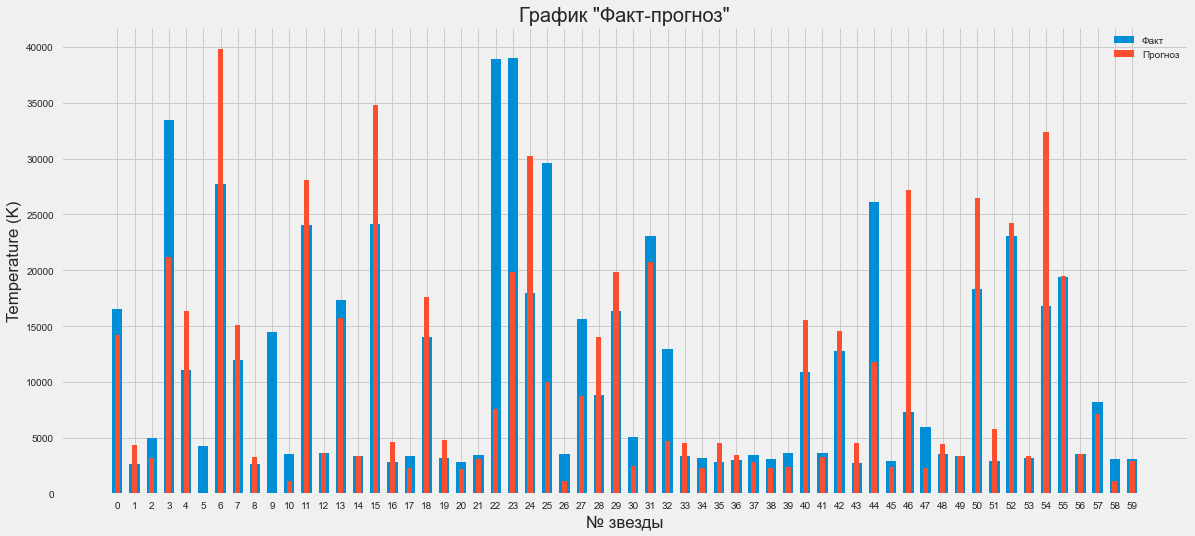

In [394]:
# Визуализируем полученные значения
fact_forecast(full_test_pred, y_test)

## Улучшение нейронной сети

In [395]:
def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 6)
    layers = []
    in_features = X_train.shape[1]
    layers.append(nn.BatchNorm1d(in_features))

    
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 2, 46)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.LeakyReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.4, 0.99)
        layers.append(nn.Dropout(p))
        in_features = out_features
    layers.append(nn.Linear(in_features, 1))
    layers.append(nn.ReLU())

    return nn.Sequential(*layers)

In [396]:
def objective(trial):
    # Generate the model.
    model = define_model(trial)
    loss = nn.MSELoss()
    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 0.1, 0.4, log=True)
    
    #optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr,weight_decay=1e-2)

    # Training of the model.
    EPOCHS=trial.suggest_int('epochs', 1000, 10000, step = 10)
    BATCHSIZE=trial.suggest_int('batch_size', 8, 90, step = 2)
    train_dataloader = DataLoader(dataset_train, batch_size=BATCHSIZE, shuffle=True,num_workers=0)
    test_dataloader = DataLoader(dataset_test, batch_size=BATCHSIZE, num_workers=0)
    #---
    early_stopper = EarlyStopper(patience=3, min_delta=100)
    for epoch in trange(EPOCHS):
        model.train()
        for batch in train_dataloader:
            features_train, targets_train = batch # просто выгружаем данные 
            optimizer.zero_grad()
            preds = model.forward(features_train).flatten()
            loss_value = torch.sqrt(loss(preds, targets_train))
            loss_value.backward()
            optimizer.step()
        if epoch % 100== 0:
            predicted = [] 
            with torch.no_grad():
                model.eval()
                for batch in test_dataloader:
                    features_test, targets_test = batch # просто выгружаем данные
                    test_preds = model.forward(features_test).flatten()
                    predicted.append(test_preds)
                    RMSE_loss = torch.sqrt(loss(test_preds, targets_test))            
            predicted = torch.cat(predicted).detach().numpy()
            try:
                RMSE = mean_squared_error(y_test, predicted, squared=False)
                
                early_stopper = EarlyStopper(patience=3, min_delta=100)
                if early_stopper.early_stop(RMSE):             
                    print('Early Stoppning!!!')
                    print(f'Last RMSE test {RMSE}')
                    break
                trial.report(rmse, epoch)
            except:
                raise optuna.exceptions.TrialPruned()
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        if early_stopper.early_stop(RMSE):             
            print('Early Stoppning!!!')
            print(f'Last RMSE test {RMSE}')
            break

    return RMSE    


In [397]:
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=75, timeout=600)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials)) 
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-11-22 17:32:54,690] A new study created in memory with name: no-name-acb173bf-e514-45cc-8a02-06f2d7442010
100%|██████████████████████████████████████████████████████████████████████████████| 7250/7250 [05:01<00:00, 24.07it/s]
[I 2023-11-22 17:37:55,871] Trial 0 finished with value: 8391.0458984375 and parameters: {'n_layers': 2, 'n_units_l0': 44, 'dropout_l0': 0.7315130827132839, 'n_units_l1': 42, 'dropout_l1': 0.4716772738720798, 'optimizer': 'Adam', 'lr': 0.134499349537254, 'epochs': 7250, 'batch_size': 74}. Best is trial 0 with value: 8391.0458984375.
  1%|█▏                                                                             | 100/6820 [00:04<04:58, 22.53it/s]
[I 2023-11-22 17:38:00,319] Trial 1 pruned. 
100%|██████████████████████████████████████████████████████████████████████████████| 7570/7570 [23:09<00:00,  5.45it/s]
[I 2023-11-22 18:01:09,803] Trial 2 finished with value: 14626.849609375 and parameters: {'n_layers': 5, 'n_units_l0': 17, 'dropout_l0': 0.9689215

Study statistics: 
  Number of finished trials:  3
  Number of pruned trials:  1
  Number of complete trials:  2
Best trial:
  Value:  8391.0458984375
  Params: 
    n_layers: 2
    n_units_l0: 44
    dropout_l0: 0.7315130827132839
    n_units_l1: 42
    dropout_l1: 0.4716772738720798
    optimizer: Adam
    lr: 0.134499349537254
    epochs: 7250
    batch_size: 74


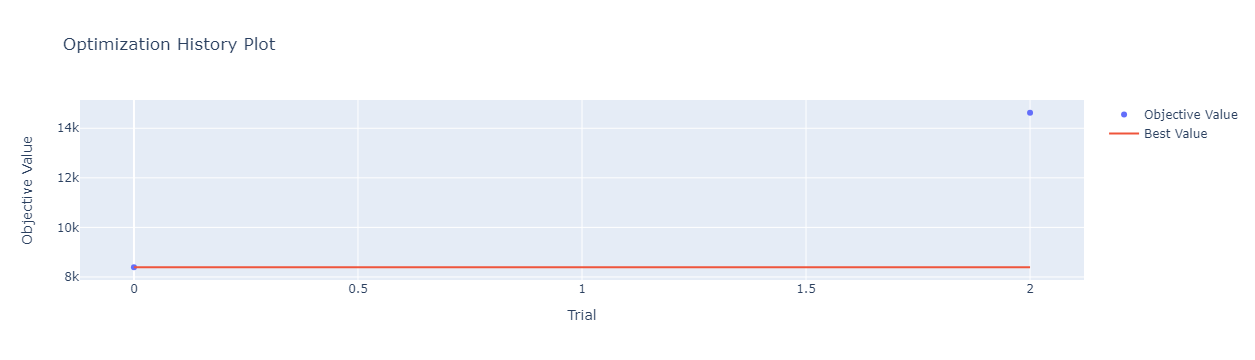

In [398]:

fig = optuna.visualization.plot_optimization_history(study)
fig.show()

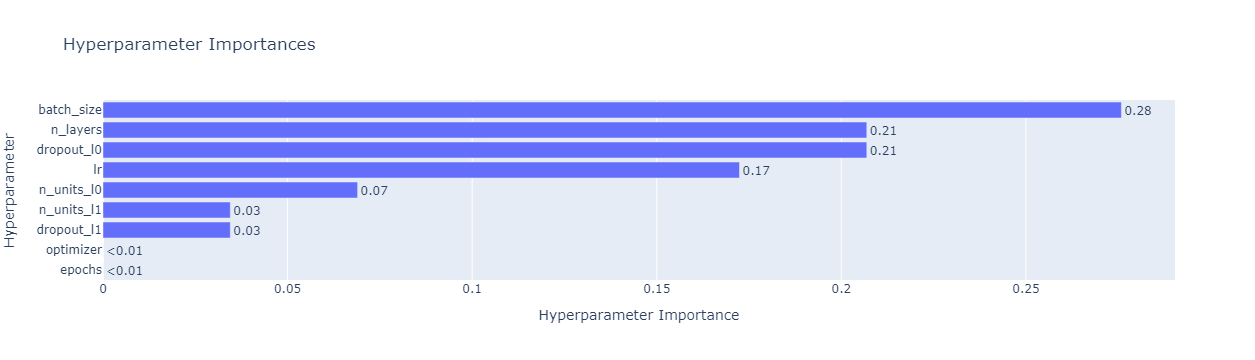

In [399]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

Best trial:
  Value:  4816.50439453125
  Params: 
    n_layers: 1
    n_units_l0: 9
    dropout_l0: 0.6282551732427866
    optimizer: RMSprop
    lr: 0.2931631656054358
    epochs: 960
    batch_size: 50

Пожалуй, тестовая метрика слишком хорошо, наверняка модель переобучилась. К счастью у нас остался кусок данных, которые модель ещё не видела.
Можем проверить.

In [ ]:
chrt=pd.DataFrame()
test_rmse=[]
tr_rmse=[]
epch=[]
for i in range(9000,15000, 1000):
    net = customize_model(ins=n_in_neurons,layers=1,neurons=[9],drops=[0.6282551732427866])
    
    optimizer = torch.optim.RMSprop(net.parameters(), lr=0.2931631656054358,weight_decay=1e-2) 
    loss = nn.MSELoss()

    epch.append(i)
    net=train_net(epochs=i, batch_size=50)
    test_rmse.append(round(mean_squared_error(y_test.detach().numpy(), net.forward(X_test).detach().numpy()))**0.5)
    tr_rmse.append(round(mean_squared_error(y_train.detach().numpy(), net.forward(X_train).detach().numpy()))**0.5)
chrt['Epochs']=epch
chrt['Test RMSE']=test_rmse
chrt['Train RMSE']=tr_rmse
chrt['Target']=4500

In [ ]:
chrt

In [ ]:

# multiple line plots
plt.plot( 'Epochs', 'Test RMSE', data=chrt, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
#plt.plot( 'Epochs', 'Validation RMSE', data=chrt, marker='', color='olive', linewidth=4, linestyle='solid')
plt.plot( 'Epochs', 'Target', data=chrt, marker='', color='red', linewidth=2, linestyle='solid')
# show legend
plt.legend()

# show graph
plt.show()